# Gym's Pacman 

## Imports 

In [32]:
import gym
import math
import random
import numpy as np
import matplotlib.pyplot as plt
from collections import namedtuple
from PIL import Image
from itertools import count

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T

## Device 

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

##  Replay Memory

We will store our agents memory to reuse this data later for training, sampling randomly for better results with our Neural Network

- So let's create a ```class``` named ```Transitions``` that will represent a transition in our environment. It stores our ```("state", "action")``` and ```("next_state", "reward")```. 
- And a ```class``` ```ReplayMemory``` with limited size that will hold transitions during our training.


In [37]:
Transition = namedtuple("Transition", 
                         ("state", "action", "next_state", "reward"))

In [5]:
class ReplayMemory(object):
    
    def __init__(self, max_size):
        """
        Creates the ReplayMemory object with the maximum size of transitions
        """
        self.max_size = max_size
        self.memory = []
        self.position = 0
        
    def push(self, *args):
        """
        Saves a transition during training
        """
        if len(self.memory) < self.max_size:
            self.memory.append(None)
        self.memory[self.position] = Transition(*args)
        self.position = (self.position + 1) % self.max_size
        
    def sample(self, batch_size):
        """
        Takes a random sample of our training memory
        """
        return random.sample(self.memory, batch_size)
    
    def __len__(self):
        """
        Defines the len() of the ReplayMemory
        """
        return len(self.memory)

## DQN 

Here we will create a **Deep Q Network** with a convolutional network that will get as ```input``` the state of the environment and will return as ```output``` the expected value for every possible action in that same state.

#### ConvNet output size:

- W: input volume
- K: kernel size
- P: padding
- D: dilation
- S: stride

$$
outSize = \frac{W +2P - D\cdot (K-1)-1}{S}+1
$$

But in this case we'll be use only Dilation=1

In [9]:
class DQN(nn.Module):
    
    def __init__(self, in_channels, h, w, outputs):
        """
        Creates the ConvNet 
        
        h: int
        The screen height
        
        w: int
        The screen width
        
        outputs: int
        The number of actions for the agent
        """
        super(DQN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, 16, kernel_size=5, stride=2)
        self.bn1 = nn.BatchNorm2d(16)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=5, stride=2)
        self.bn2 = nn.BatchNorm2d(32)
        self.conv3 = nn.Conv2d(32, 32, kernel_size=5, stride=2)
        self.bn3 = nn.BatchNorm2d(32)
        
        # Calculate the output size of conv to be the input of linear
        def conv2d_size_out(size, kernel_size = 5, stride = 2):
            return (size - (kernel_size - 1) - 1) // stride  + 1
        
        convw = conv2d_size_out(conv2d_size_out(conv2d_size_out(w)))
        convh = conv2d_size_out(conv2d_size_out(conv2d_size_out(h)))
        linear_input_size = convw * convh * 32
        self.head = nn.Linear(linear_input_size, outputs)   
        
    def forward(self, x):
        """
        Pass a batch through the ConvNet
        """
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.relu(self.bn3(self.conv3(x)))
        return self.head(x.view(x.size(0), -1))

## Image Processing 

In this application, our input (our state) will be the images of Pacman, then we need to process these to use in out network

In [19]:
resize = T.Compose([T.ToPILImage(),
                    T.Resize(40, interpolation=Image.CUBIC),
                    T.ToTensor()])
def get_screen(env):
    screen = env.render(mode="rgb_array").transpose((2, 0, 1))  # HxWxC to CxHxW
    _, screen_height, screen_width = screen.shape
    screen = screen[:, int(screen_height*0.4):int(screen_height * 0.8)]
    screen = np.ascontiguousarray(screen, dtype=np.float32) / 255
    screen = torch.from_numpy(screen)
    # Resize, and add a batch dimension (BCHW)
    return resize(screen).unsqueeze(0).to(device)

## Main 

In [11]:
env = gym.make('MsPacman-v0')

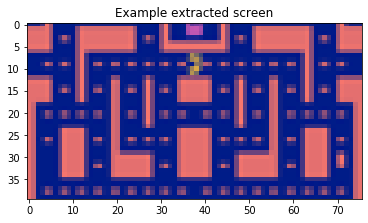

In [20]:
env.reset()
plt.figure()
plt.imshow(get_screen(env).cpu().squeeze(0).permute(1, 2, 0).numpy(),
           interpolation='none')
plt.title('Example extracted screen')
plt.show()

## Training 

### Hyperparameters 

In [23]:
BATCH_SIZE = 128
GAMMA = 0.999
EPS_START = 0.9
EPS_END = 0.05
EPS_DECAY = 200
TARGET_UPDATE = 10
MAX_MEMORY = 10000

### Creating DQN's 

In [25]:
init_screen = get_screen(env)
_, in_channels, screen_height, screen_width = init_screen.shape

n_actions = env.action_space.n

policy_net = DQN(in_channels, screen_height, screen_width, n_actions).to(device)
target_net = DQN(in_channels, screen_height, screen_width, n_actions).to(device)
target_net.load_state_dict(policy_net.state_dict())
target_net.eval()

optimizer = optim.RMSprop(policy_net.parameters())
memory = ReplayMemory(MAX_MEMORY)

steps_done = 0

In [26]:
def select_action(state):
    global steps_done
    sample = random.random()
    eps_threshold = EPS_END + (EPS_START - EPS_END) * math.exp(-1. * steps_done / EPS_DECAY)
    steps_done += 1
    if sample > eps_threshold:
        with torch.no_grad():
            # t.max(1) will return largest column value of each row.
            # second column on max result is index of where max element was
            # found, so we pick action with the larger expected reward.
            return policy_net(state).max(1)[1].view(1, 1)
    else:
        return torch.tensor([[random.randrange(n_actions)]], device=device, dtype=torch.long)


episode_durations = []


def plot_durations():
    plt.figure(2)
    plt.clf()
    durations_t = torch.tensor(episode_durations, dtype=torch.float)
    plt.title('Training...')
    plt.xlabel('Episode')
    plt.ylabel('Duration')
    plt.plot(durations_t.numpy())
    # Take 100 episode averages and plot them too
    if len(durations_t) >= 100:
        means = durations_t.unfold(0, 100, 1).mean(1).view(-1)
        means = torch.cat((torch.zeros(99), means))
        plt.plot(means.numpy())

    plt.pause(0.001)  # pause a bit so that plots are updated
    if is_ipython:
        display.clear_output(wait=True)
        display.display(plt.gcf())    

## Training Loop 

In [27]:
def optimize_model():
    if len(memory) < BATCH_SIZE:
        return
    transitions = memory.sample(BATCH_SIZE)
    # Transpose the batch (see https://stackoverflow.com/a/19343/3343043 for
    # detailed explanation). This converts batch-array of Transitions
    # to Transition of batch-arrays.
    batch = Transition(*zip(*transitions))

    # Compute a mask of non-final states and concatenate the batch elements
    # (a final state would've been the one after which simulation ended)
    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None,
                                          batch.next_state)), device=device, dtype=torch.bool)
    non_final_next_states = torch.cat([s for s in batch.next_state
                                                if s is not None])
    state_batch = torch.cat(batch.state)
    action_batch = torch.cat(batch.action)
    reward_batch = torch.cat(batch.reward)

    # Compute Q(s_t, a) - the model computes Q(s_t), then we select the
    # columns of actions taken. These are the actions which would've been taken
    # for each batch state according to policy_net
    state_action_values = policy_net(state_batch).gather(1, action_batch)

    # Compute V(s_{t+1}) for all next states.
    # Expected values of actions for non_final_next_states are computed based
    # on the "older" target_net; selecting their best reward with max(1)[0].
    # This is merged based on the mask, such that we'll have either the expected
    # state value or 0 in case the state was final.
    next_state_values = torch.zeros(BATCH_SIZE, device=device)
    next_state_values[non_final_mask] = target_net(non_final_next_states).max(1)[0].detach()
    # Compute the expected Q values
    expected_state_action_values = (next_state_values * GAMMA) + reward_batch

    # Compute Huber loss
    loss = F.smooth_l1_loss(state_action_values, expected_state_action_values.unsqueeze(1))

    # Optimize the model
    optimizer.zero_grad()
    loss.backward()
    for param in policy_net.parameters():
        param.grad.data.clamp_(-1, 1)
    optimizer.step()

In [38]:
num_episodes = 50
for i_episode in range(num_episodes):
    # Initialize the environment and state
    env.reset()
    last_screen = get_screen(env)
    current_screen = get_screen(env)
    state = current_screen - last_screen
    for t in count():
        # Select and perform an action
        action = select_action(state)
        _, reward, done, _ = env.step(action.item())
        reward = torch.tensor([reward], device=device)

        # Observe new state
        last_screen = current_screen
        current_screen = get_screen(env)
        if not done:
            next_state = current_screen - last_screen
        else:
            next_state = None

        # Store the transition in memory
        memory.push(state, action, next_state, reward)

        # Move to the next state
        state = next_state

        # Perform one step of the optimization (on the target network)
        optimize_model()
        if done:
            episode_durations.append(t + 1)
            plot_durations()
            break
    # Update the target network, copying all weights and biases in DQN
    if i_episode % TARGET_UPDATE == 0:
        target_net.load_state_dict(policy_net.state_dict())

print('Complete')
env.render()
env.close()
plt.ioff()
plt.show()

TypeError: zip argument #66 must support iteration

In [42]:
a = np.random.randn(3, 3)
b = np.random.randn(3, 1)
c = a*b
print(a)
print(b)
print(c, c.shape)

[[ 1.48326588  0.32935736  0.09632282]
 [ 0.23085226  0.09634725 -1.15553888]
 [-0.06260528  0.07440611 -1.12165264]]
[[-0.02935934]
 [-0.46074976]
 [-2.27293108]]
[[-0.04354771 -0.00966971 -0.00282797]
 [-0.10636512 -0.04439197  0.53241426]
 [ 0.14229748 -0.16911997  2.54943914]] (3, 3)
